## MATH1042: Peluang dan Statistika
# Tugas Pemrograman Proyek 4B
## Kelompok 2

### Daftar Tugas
#### Pemrograman
1. Grafik relasi semua parameter dgn harga jual rumah
2. Regresi linear utk cari hubungan antara parameter
3. inferensi statistika - koefisien hasil regresi
4. visualisasi data

In [46]:
# Import library yang dibutuhkan. 
## Numpy untuk kalkulasi utama
## pandas untuk membuka dataset
## matplotlib untuk visualisasi
## dan scipy.stats untuk menghitung t-value
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stat

In [47]:
data_raw = pd.read_csv("House_Prices.csv") # membuka data
data = data_raw[["YearBuilt", "BsmtFinSF1", "BsmtUnfSF", "1stFlrSF", "2ndFlrSF", "SalePrice"]] # mengambil kategori yang dibutuhkan
firstfloor_data = data["1stFlrSF"]
secondfloor_data = data["2ndFlrSF"]
data["1st&2ndFlrSF"] = firstfloor_data+secondfloor_data # membuat kategori baru (luas bangunan)

<ipython-input-47-603183d240b3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["1st&2ndFlrSF"] = firstfloor_data+secondfloor_data # membuat kategori baru (luas bangunan)


In [48]:
class HouseSpec:  # class utama untuk tiap kategori
    def __init__(self, column_name):  #column name adalah string nama kategori
        self.data = np.array(data[[column_name]])
        self.category = column_name


class LinearRegression(HouseSpec):  # subclass untuk membandingkan dua kategori rumah. Inherits HouseSpec superclass
    def __init__(self, independent, dependent):
        self.raw_independent = independent
        self.raw_dependent = dependent
        self.description = f"{self.raw_independent.category} - {self.raw_dependent.category}"
        self.raw_n = len(self.raw_independent.data)
        assert self.raw_n == len(self.raw_dependent.data)  # memastikan variabel independen dan dependen memiliki ukuran sama

        self.filtered = self.filter_zero()  # menggunakan method untuk menghilangkan nilai-nilai nol dari kategori
        self.independent = self.filtered[0]
        self.independent_mean = self.independent.mean()  # rata-rata variabel independen
        self.dependent = self.filtered[1]
        self.dependent_mean = self.dependent.mean()  # rata-rata variabel dependen
        self.n = self.filtered[2]

        self.b1 = round(self.gradient(x_axis=self.independent, y_axis=self.dependent), 2)  # nilai b1 regresi
        self.b0 = round(self.intercept(x_axis=self.independent, y_axis=self.dependent), 2)  # nilai b0 regresi
        self.str_function = self.string_function(b1=self.b1, b0=self.b0)  # string fungsi y=mx+b 
        self.regression_x = np.linspace(min(self.independent), max(self.independent), self.n)  # linearspace untuk visualisasi fungsi
        self.regression_y = self.regression_function(self.regression_x, self.b1, self.b0)  # nilai y untuk tiap elemen dalam regression_x

        self.ss = self.calculate_sse()
        self.sse = self.ss[0]
        self.syy = self.ss[1]
        self.sxy = self.ss[2]
        self.sxx = self.ss[3]
        self.s = np.sqrt(self.sse / (self.n - 2))

        self.korelasi = self.sxy / (np.sqrt(self.sxx * self.syy))
        self.determinasi = self.korelasi ** 2

        self.ci_b1 = self.confidence_slope(0.95)  # confidence interval b1
        self.ci_b0 = self.confidence_intercept(0.95)  # confidence interval b0
        self.ci_y0 = self.confidence_y(confidence=0.95, x0=1750)  # confidence interval y0

        self.upper_b1 = round(self.ci_b1[1], 4)
        self.lower_b1 = round(self.ci_b1[0], 4)

        self.upper_b0 = round(self.ci_b0[1], 4)
        self.lower_b0 = round(self.ci_b0[0], 4)

        self.upper_y0 = round(self.ci_y0[1], 4)
        self.lower_y0 = round(self.ci_y0[0], 4)

    @staticmethod
    def string_function(b1, b0): # method untuk mencetak fungsi 
        if b0 < 0:
            return f"y = {b1}x {b0}"
        else:
            return f"y = {b1}x + {b0}"

    def filter_zero(self): # method untuk menghilangkan data di mana variabel independen bernilai 0.
        new_independent = []
        new_dependent = []
        for i in range(self.raw_n):
            if self.raw_independent.data[i][0] == 0:
                continue
            else:
                new_independent.append(self.raw_independent.data[i][0])
                new_dependent.append(self.raw_dependent.data[i][0]) # Menghilangkan data juga di var. dependen 
        n = len(new_independent)
        assert len(new_independent) == len(new_dependent)
        return np.array(new_independent), np.array(new_dependent), n

    def gradient(self, x_axis, y_axis): # kalkulasi nilai b1
        sum_xi_yi = 0
        sum_xi = 0
        sum_yi = 0
        sum_xi_squared = 0

        for i in range(self.n):
            x = x_axis[i]
            y = y_axis[i]

            sum_xi_yi += x * y
            sum_xi += x
            sum_yi += y
            sum_xi_squared += x ** 2

        sum_squared_xi = sum_xi ** 2
        num = (self.raw_n * sum_xi_yi) - sum_xi * sum_yi
        den = (self.raw_n * sum_xi_squared) - sum_squared_xi
        return float(num / den)

    def intercept(self, x_axis, y_axis): # kalkulasi nilai b0
        return float(y_axis.mean() - self.b1 * x_axis.mean())

    @staticmethod
    def regression_function(x, b1, b0): # fungsi regresi
        return b1 * x + b0

    def plot_linear(self): # method untuk visualisasi data 
        plt.figure(figsize=(12, 10))
        plt.title(f"Linear Regression-Least Squared Error"
                  f"\n{self.raw_independent.category} - {self.raw_dependent.category}"
                  f"\nr: {self.korelasi}, R^2: {self.determinasi}")
        plt.xlabel(self.raw_independent.category)
        plt.ylabel(self.raw_dependent.category)
        plt.grid()
        plt.scatter(self.independent, self.dependent, s=8)
        # regression function
        plt.plot(self.regression_x,
                 self.regression_y,
                 color="red",
                 label=self.str_function)

        if self.raw_independent.category != "YearBuilt":
            plt.plot(self.regression_x,
                     self.regression_function(self.regression_x, self.upper_b1, self.upper_b0),
                     color="green",
                     linestyle="dashed",
                     label=self.string_function(b1=self.upper_b1, b0=self.upper_b0))
            plt.plot(self.regression_x,
                     self.regression_function(self.regression_x, self.lower_b1, self.lower_b0),
                     color="pink",
                     linestyle="dashed",
                     label=self.string_function(b1=self.lower_b1, b0=self.lower_b0))
        else:
            plt.plot(self.regression_x,
                     self.regression_function(self.regression_x, self.upper_b1, self.lower_b0),
                     color="blue",
                     linestyle="dashed",
                     label=self.string_function(b1=self.upper_b1, b0=self.lower_b0))

            plt.plot(self.regression_x,
                     self.regression_function(self.regression_x, self.lower_b1, self.upper_b0),
                     color="grey",
                     linestyle="dashed",
                     label=self.string_function(b1=self.lower_b1, b0=self.upper_b0))

        plt.legend(loc="upper right")

    def plot_prediction(self, convidence=0.95, val=None): # method untuk visualisasi data dengan confidence interval dan nilai x0
        result = self.prediction(convidence, val)
        low = result[0]
        high = result[1]
        low_result = result[2]
        high_result = result[3]
        if val:
            print(f"Predicting {val} Value")
            print("low", ",", "high")
            print(low_result, ",", high_result)

        plt.figure(figsize=(12, 10))
        plt.title(f"Linear Regression-Prediction Result"
                  f"\n{self.raw_independent.category} - {self.raw_dependent.category}"
                  f"\nr: {self.korelasi}, R^2: {self.determinasi}")
        plt.xlabel(self.raw_independent.category)
        plt.ylabel(self.raw_dependent.category)
        plt.grid()
        plt.scatter(self.independent, self.dependent, s=8)
        # regression function
        plt.plot(self.regression_x,
                 self.regression_y,
                 color="red",
                 label=self.str_function)
        plt.vlines(x=val, ymin=0, ymax=600000)
        plt.plot(self.regression_x,
                 self.regression_function(self.regression_x, self.upper_b1, self.lower_b0),
                 color="blue",
                 linestyle="dashed",
                 label=self.string_function(b1=self.upper_b1, b0=self.lower_b0))

        plt.plot(self.regression_x,
                 self.regression_function(self.regression_x, self.lower_b1, self.upper_b0),
                 color="grey",
                 linestyle="dashed",
                 label=self.string_function(b1=self.lower_b1, b0=self.upper_b0))

        plt.plot(self.regression_x,
                 low,
                 color="orange",
                 linestyle="dashed",
                 )

        plt.plot(self.regression_x,
                 high,
                 color="orange",
                 linestyle="dashed",
                 )

        plt.legend(loc="upper right")

    def calculate_sse(self): 
        sum_squared_error = 0
        s_yy = 0
        s_xy = 0
        s_xx = 0
        if self.regression_y is not None: # harus mendapatkan nilai regresi dulu sebelum mengkalkulasi SSE, Syy, Sxy, Sxx
            for i in range(self.n):
                # sum_squared_error += (self.dependent[i] - self.regression_y[i]) ** 2
                sum_squared_error += (self.dependent[i] - self.regression_function(x=i, b1=self.b1, b0=self.b0)) ** 2
                s_yy += (self.dependent[i] - self.dependent_mean) ** 2
                s_xy += (self.independent[i] - self.independent_mean) * (self.dependent[i] - self.dependent_mean)
                s_xx += (self.independent[i] - self.independent_mean) ** 2
            return sum_squared_error, s_yy, s_xy, s_xx
        else:
            print("Lakukan Regresi Linear dulu!!")
            return

    def confidence_slope(self, confidence): # interval keyakinan untuk b1
        if 0 < confidence < 1:
            dof = self.n - 2
            t_val = abs(stat.t.ppf((1 - confidence) / 2, dof))
            up = self.b1 + (t_val * self.s / np.sqrt(self.sxx))
            low = self.b1 - (t_val * self.s / np.sqrt(self.sxx))
            return low, up
        else:
            print("Confidence harus bernilai 0 sampai 1!")
            return

    def confidence_intercept(self, confidence): # interval keyakinan untuk b0
        if 0 < confidence < 1:
            dof = self.n - 2
            t_val = abs(stat.t.ppf((1 - confidence) / 2, dof))
            sum_x = 0
            for i in range(self.n):
                sum_x += self.independent[i] ** 2
            sum_x_sqrt = np.sqrt(sum_x)
            up = self.b0 + (t_val * self.s * sum_x_sqrt / np.sqrt(self.n * self.sxx))
            low = self.b0 - (t_val * self.s * sum_x_sqrt / np.sqrt(self.n * self.sxx))
            return low, up
        else:
            print("Confidence harus bernilai 0 sampai 1!")
            return

    def confidence_y(self, confidence, x0): # interval keyakinan untuk y0
        if 0 < confidence < 1:
            y_hat = self.regression_function(x=x0, b1=self.b1, b0=self.b0)
            dof = self.n - 2
            t_val = abs(stat.t.ppf((1 - confidence) / 2, dof))
            up = y_hat + t_val * np.sqrt(1 + 1 / self.n + (((x0 - self.independent_mean) ** 2) / self.sxx))
            low = y_hat - t_val * np.sqrt(1 + 1 / self.n + (((x0 - self.independent_mean) ** 2) / self.sxx))
            return low, up
        else:
            print("Confidence harus bernilai 0 sampai 1!")
            return
 
    def describe_all(self): # method sederhana untuk mencetak atribut objek yang diperlukan
        print(f"category: {self.description}")
        print(f"str_function: {self.str_function}")
        print(f"s: {self.s}")
        print(f"sse: {self.sse}")
        print(f"syy: {self.syy}")
        print(f"sxy: {self.sxy}")
        print(f"sxx: {self.sxx}")
        print(f"r: {self.korelasi}")
        print(f"R: {self.determinasi}\n")

    def prediction(self, confidence, valpred=None): # mengkalkulasi nilai prediksi, digunakan dalam method plot_prediction
        dof = self.n - 2
        t_val = abs(stat.t.ppf((1 - confidence) / 2, dof))
        low = []
        high = []
        for i in range(len(self.regression_x)):
            y_hat = self.regression_function(self.regression_x[i], self.b1, self.b0)
            low_result = y_hat - t_val * np.sqrt(1 + 1 / self.n + (
                    self.regression_x[i] - self.dependent_mean) ** 2 / self.sxx)
            high_result = y_hat + t_val * np.sqrt(1 + 1 / self.n + (
                    self.regression_x[i] - self.dependent_mean) ** 2 / self.sxx)
            low.append(low_result)
            high.append(high_result)
        if valpred:
            y_hat = self.regression_function(valpred, self.b1, self.b0)
            low_result = y_hat - t_val * np.sqrt(1 + 1 / self.n + (valpred - self.dependent_mean) ** 2 / self.sxx)
            high_result = y_hat + t_val * np.sqrt(1 + 1 / self.n + (valpred - self.dependent_mean) ** 2 / self.sxx)
        return low, high, low_result, high_result



In [49]:
# inisialisasi objek HouseSpec
yearbuilt = HouseSpec("YearBuilt")
basementfinished = HouseSpec("BsmtFinSF1")
basementunfinished = HouseSpec("BsmtUnfSF")
firstfloor = HouseSpec("1stFlrSF")
secondfloor = HouseSpec("2ndFlrSF")
firstsecondfloor = HouseSpec("1st&2ndFlrSF")

saleprice = HouseSpec("SalePrice")


yb_sp = LinearRegression(yearbuilt, saleprice)
bf_sp = LinearRegression(basementfinished, saleprice)
bu_sp = LinearRegression(basementunfinished, saleprice)
ff_sp = LinearRegression(firstfloor, saleprice)
sf_sp = LinearRegression(secondfloor, saleprice)
ff_sf_sp = LinearRegression(firstsecondfloor, saleprice)

In [50]:
yb_sp.describe_all()
bf_sp.describe_all()
bu_sp.describe_all()
ff_sp.describe_all()
ff_sf_sp.describe_all()

category: YearBuilt - SalePrice
str_function: y = 1375.37x -2530301.41
s: 1807126.3799746903
sse: 4761398988166224.0
syy: 9207911334609.98
sxy: 1830515201.4068496
sxx: 1330922.2869863021
r: 0.5228973328794967
R: 0.27342162073249116

category: BsmtFinSF1 - SalePrice
str_function: y = 180.29x + 70565.04
s: 101447.29849866778
sse: 10198930383323.701
syy: 6610423435541.634
sxy: 15736349898.103727
sxx: 168369958.1711983
r: 0.4716904265235731
R: 0.22249185847399033

category: BsmtUnfSF - SalePrice
str_function: y = 70.73x + 141142.21
s: 85593.56664083876
sse: 9817186591401.607
syy: 8674115161516.894
sxy: 7779843257.197469
sxx: 243558170.63263786
r: 0.16926100049514192
R: 0.028649286288616432

category: 1stFlrSF - SalePrice
str_function: y = 124.5x + 36174.17
s: 110305.49611508005
sse: 17739927005916.766
syy: 9207911334609.98
sxy: 27147070035.760334
sxx: 218047665.5582186
r: 0.6058521846919166
R: 0.36705686969596824

category: 1st&2ndFlrSF - SalePrice
str_function: y = 109.28x + 15950.01
s: 1

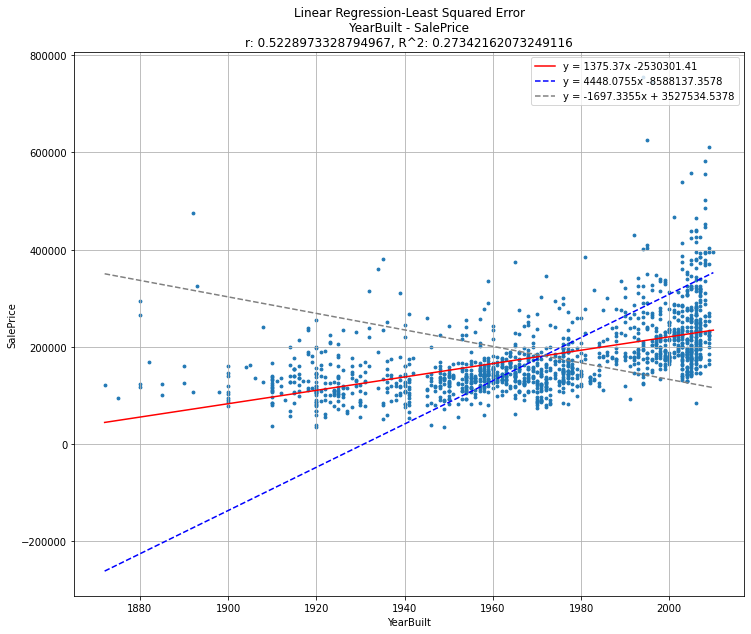

In [51]:

yb_sp.plot_linear()

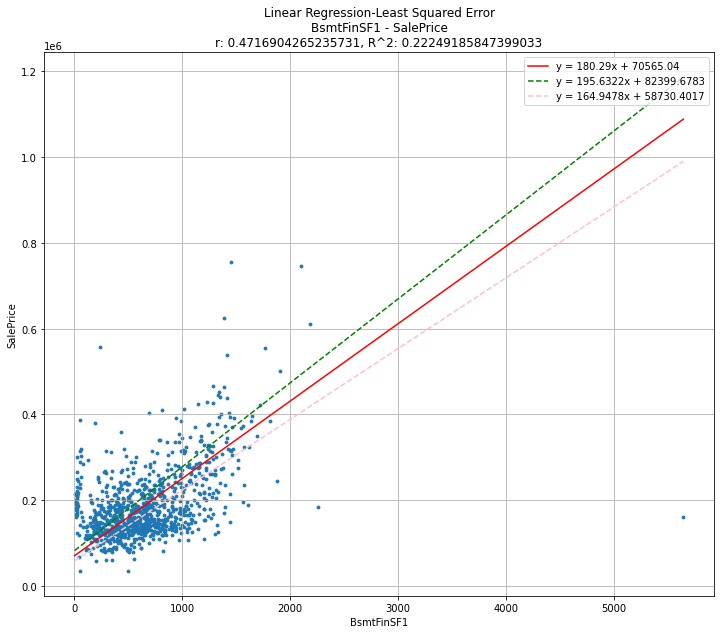

In [52]:
bf_sp.plot_linear()

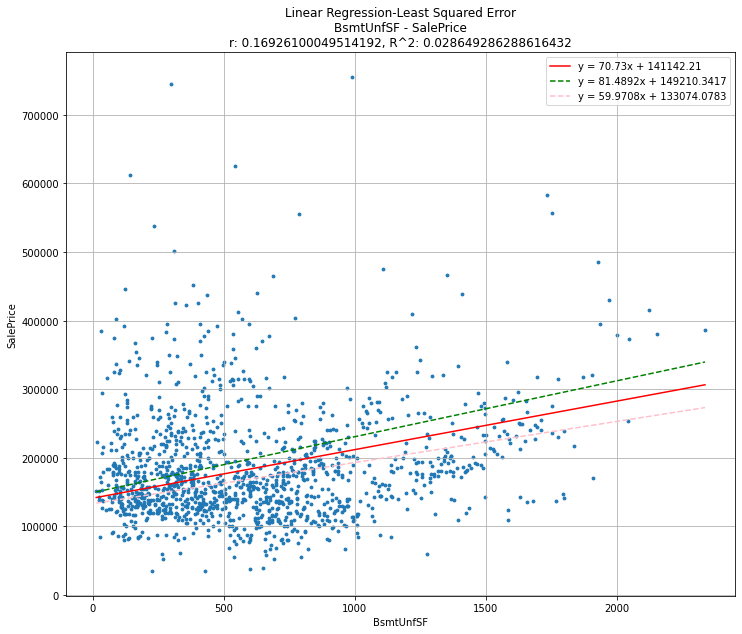

In [53]:
bu_sp.plot_linear()

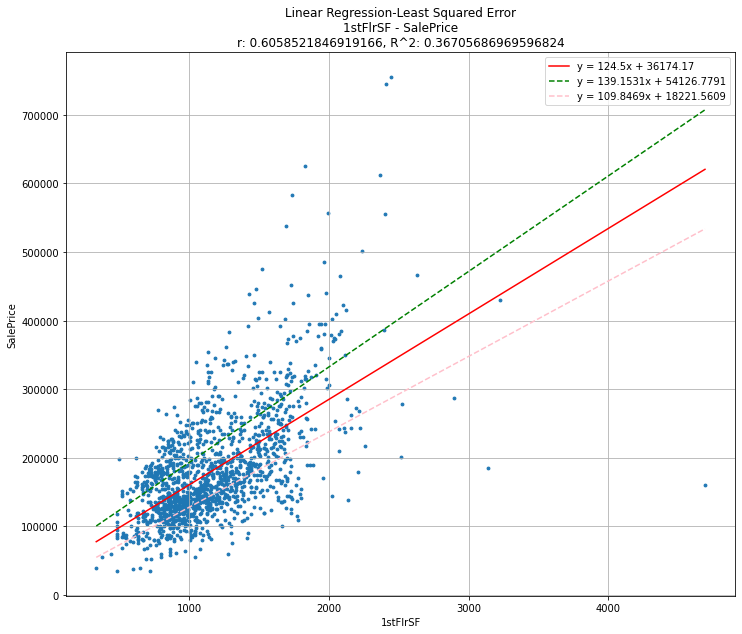

In [54]:
ff_sp.plot_linear()

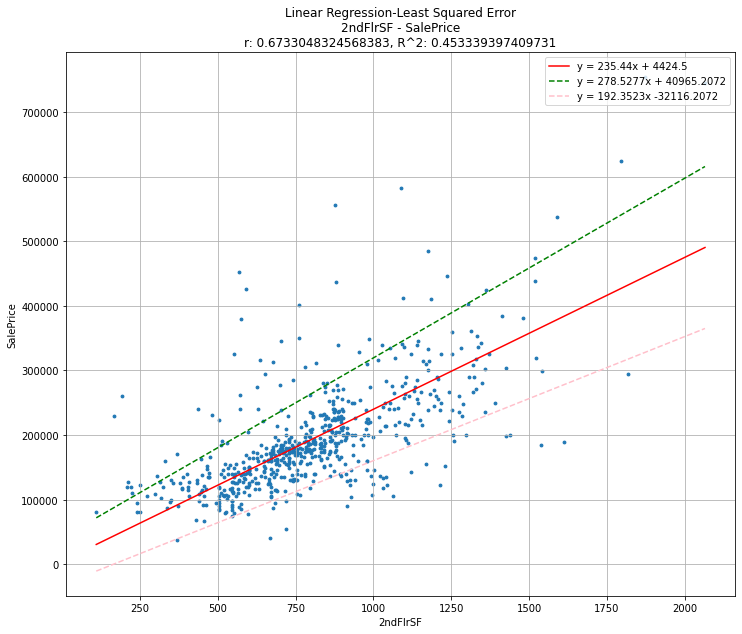

In [55]:
sf_sp.plot_linear()

In [56]:
# ff_sp.plot_log()

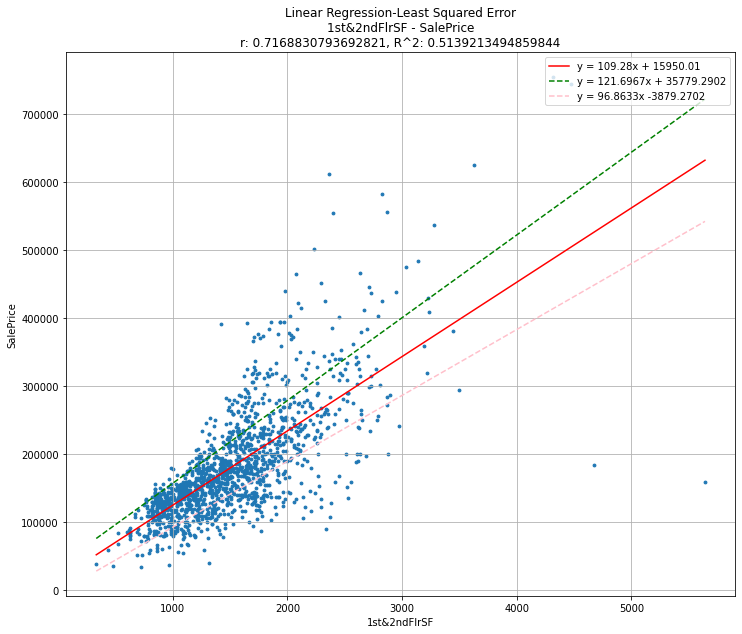

In [57]:
ff_sf_sp.plot_linear()

Predicting 1750 Value
low , high
254025.28791835712 , 254073.05208164285


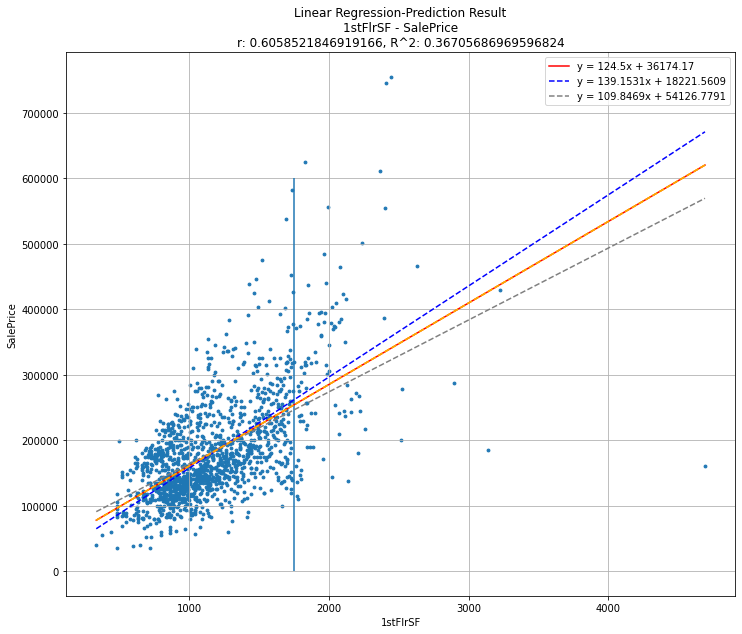

In [58]:
ff_sp.plot_prediction(val=1750)

Predicting 1750 Value
low , high
416389.59600881295 , 416499.40399118705


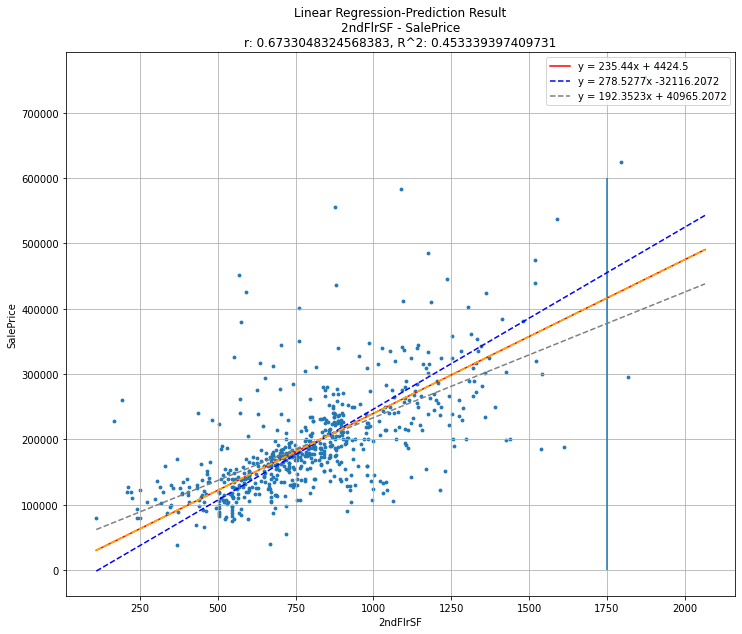

In [59]:
sf_sp.plot_prediction(val = 1750)

Predicting 1750 Value
low , high
207172.24598056337 , 207207.77401943665


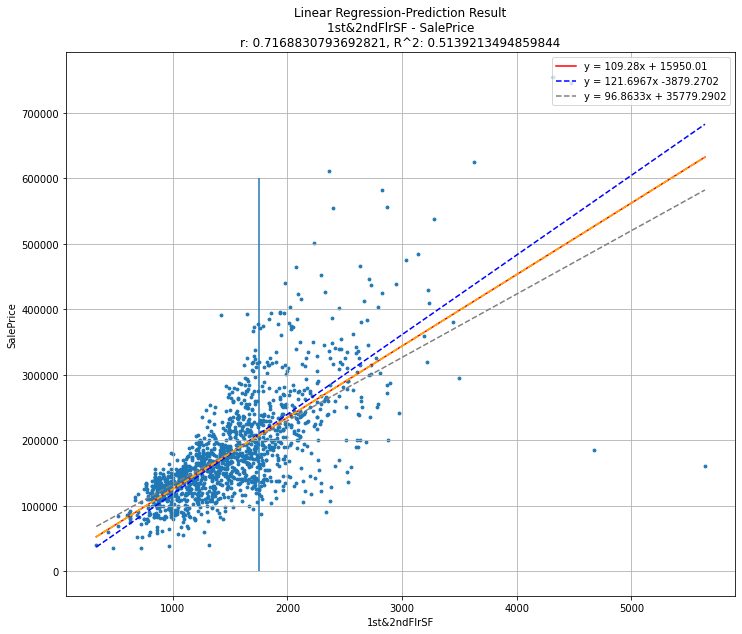

In [60]:
ff_sf_sp.plot_prediction(val=1750)